In [1]:
data_path = '../../dataset/bird_datasets/train'
classes_path = '../../dataset/bird_datasets/classes.txt'
training_labels_path = '../../dataset/bird_datasets/training_labels.txt'

BATCH_SIZE = 8
WORKERS = 16

In [2]:
import os
import torch
import numpy as np
import math
import glob
from os import listdir
from os import walk
from torch import nn
from tqdm import tqdm 
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR, StepLR, ReduceLROnPlateau
from torchvision import datasets, transforms
# from swin_transformer_pytorch import SwinTransformer
import torchvision.models as models
from src.loss_functions.CrossEntropyLS import CrossEntropyLS
from src.loss_functions.triplet_loss import TripletLoss

import PIL.Image as Image
from matplotlib import pyplot as plt
import torch.nn.functional as F
import timm
from torch.cuda.amp import GradScaler, autocast

In [3]:
imageSize = 224
def get_aug_trnsform(img_size = imageSize):
    transform = transforms.Compose(
        [
#             transforms.RandomResizedCrop(img_size, scale=(0.2, 1.0)),
#             transforms.RandomApply(
#                 [
#                     transforms.ColorJitter(
#                         0.4, 0.4, 0.4, 0.1
#                     )  # not strengthened
#                 ],
#                 p=0.8,
#             ),
#             transforms.RandomGrayscale(p=0.2),
#             transforms.RandomApply([GaussianBlur([0.1, 2.0])], p=0.5),
#             transforms.RandomHorizontalFlip(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
#             normalize,
        ]
    )
    return transform

In [4]:
from PIL import ImageFilter
import random
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

class GaussianBlur(object):
    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [7]:
class_to_idx = {}
with open(classes_path) as f:
    for line in f.readlines():
        label_num =  line.split(".")[0] 
        label_str =  line.split(".")[1][:-1]
        class_to_idx[int(label_num) - 1] = label_str

FileNotFoundError: [Errno 2] No such file or directory: '../../dataset/bird_datasets/classes.txt'

In [83]:
data_list = []
with open(training_labels_path) as f:
    for line in f.readlines():
        file_name =  line.split(" ")[0]
        label_num =  int(line.split(" ")[1].split(".")[0]) -1
        label_str =  line.split(" ")[1].split(".")[1][:-1]
        data_list.append([file_name, label_num, label_str])

train_data_list = data_list[:int(len(data_list) * 0.8)]
val_data_list = data_list[int(len(data_list) * 0.8):int(len(data_list) * 0.9)]
test_data_list = data_list[int(len(data_list) * 0.9):]

0it [00:00, ?it/s]

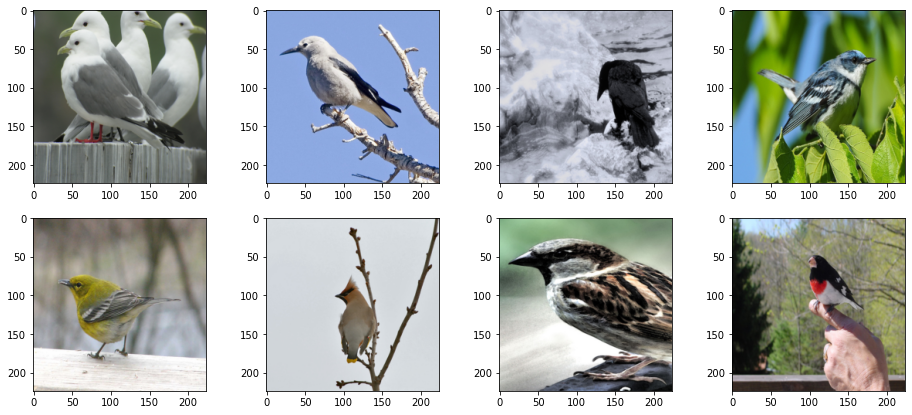

0it [00:01, ?it/s]

tensor([ 83,  92,  29, 163, 174, 184, 117,  56])
torch.Size([8])


In [84]:
dataset_debug = BirdImageLoader(data_path, train_data_list, class_to_idx, transform=get_aug_trnsform())
debug_loader = DataLoader(
    dataset_debug,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

imgs = []
for i_batch, image_batch in tqdm(enumerate(debug_loader)):
    x, y = image_batch[0], image_batch[1]
    ROW, COL = 2, 4
    f, ax = plt.subplots(ROW, COL, figsize=(16, 7))
    for i in range(ROW):
        for j in range(COL):
            img = x[i*COL+j]
            imgs.append(img)
            ax[i][j].imshow(img.permute(1, 2, 0))
    plt.show()
    break
print(y)
print(y.size())

In [8]:
myImage = imgs[3]


NameError: name 'imgs' is not defined

In [20]:
import cv2
test_path = '../../DATA/Nuclei/dataset/test/TCGA-G2-A2EK-01A-02-TSB.png'
image_bgr = cv2.imread(test_path, cv2.IMREAD_COLOR)
# image_bgr
img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
myImage = torch.tensor(img_rgb)
myImage.size()

torch.Size([1000, 1000, 3])

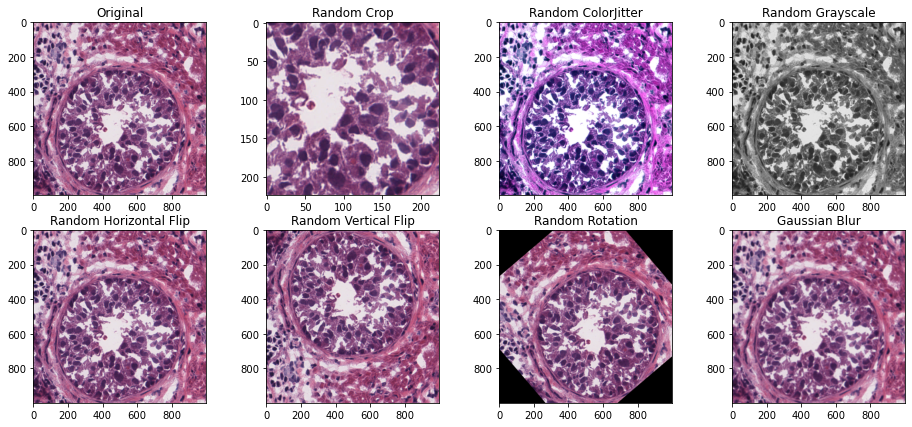

In [23]:
ROW, COL = 2,  4
f, ax = plt.subplots(ROW, COL, figsize=(16, 7))
myImage = torch.tensor(img_rgb)

a1 = transforms.RandomResizedCrop(224, scale=(0.2, 0.4))
a2 = transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)],p=1.0)
a3 = transforms.RandomGrayscale(p=1.0)
a4 = transforms.RandomHorizontalFlip()
a5 = transforms.RandomVerticalFlip()
a6 = transforms.RandomRotation(degrees=360)
a7 = transforms.GaussianBlur(7, 3)

ax[0][0].imshow(myImage)
myImage = myImage.permute(2,0,1)
ax[0][1].imshow(a1(myImage).permute(1, 2, 0))
ax[0][2].imshow(a2(myImage).permute(1, 2, 0))
ax[0][3].imshow(a3(myImage).permute(1, 2, 0))
ax[1][0].imshow(a4(myImage).permute(1, 2, 0))
ax[1][1].imshow(a5(myImage).permute(1, 2, 0))
ax[1][2].imshow(a6(myImage).permute(1, 2, 0))
ax[1][3].imshow(a7(myImage).permute(1, 2, 0))

ax[0][0].set_title('Original')
ax[0][1].set_title('Random Crop')
ax[0][2].set_title('Random ColorJitter')
ax[0][3].set_title('Random Grayscale')
ax[1][0].set_title('Random Horizontal Flip')
ax[1][1].set_title('Random Vertical Flip')
ax[1][2].set_title('Random Rotation')
ax[1][3].set_title('Gaussian Blur')

plt.savefig('transforms.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


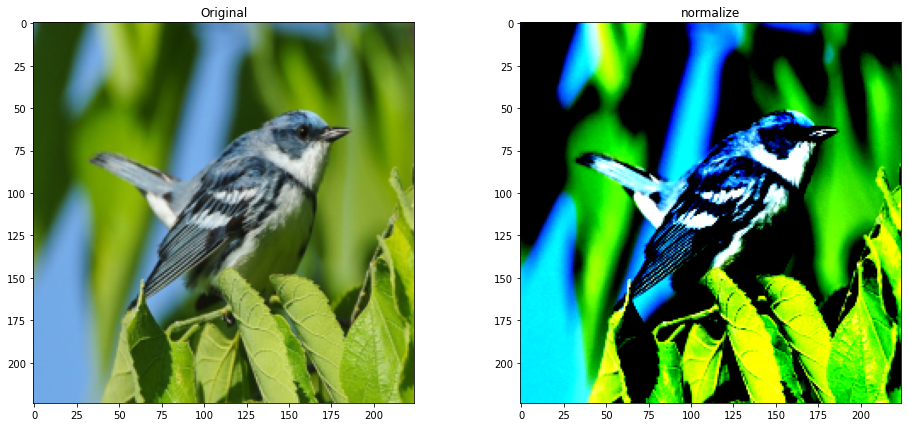

In [129]:
ROW, COL = 1,  2
f, ax = plt.subplots(ROW, COL, figsize=(16, 7))

a1 = normalize

ax[0].imshow(myImage.permute(1, 2, 0))
ax[1].imshow(a1(myImage).permute(1, 2, 0))

ax[0].set_title('Original')
ax[1].set_title('normalize')


plt.savefig('normalize.png')
plt.show()

In [ ]:
normalize